<a href="https://colab.research.google.com/github/Imshubhham/Imshubham/blob/main/Large_Scale_fish_Dataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [4]:
%cd '/content/drive/MyDrive/Kaggle'

/content/drive/MyDrive/Kaggle


In [7]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:46<00:00, 71.2MB/s]
100% 3.24G/3.24G [00:46<00:00, 74.3MB/s]


In [8]:
import zipfile

# Path to the zip file on your Google Drive
zip_file_path = '/content/drive/MyDrive/Kaggle/a-large-scale-fish-dataset.zip'

# Directory where you want to extract the contents
extract_path = '/content/drive/MyDrive/Kaggle'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [6]:
from os import listdir
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split

In [7]:
DIR = '//content/drive/MyDrive/Kaggle/Fish_Dataset/Fish_Dataset'  #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]
classes

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [8]:
label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


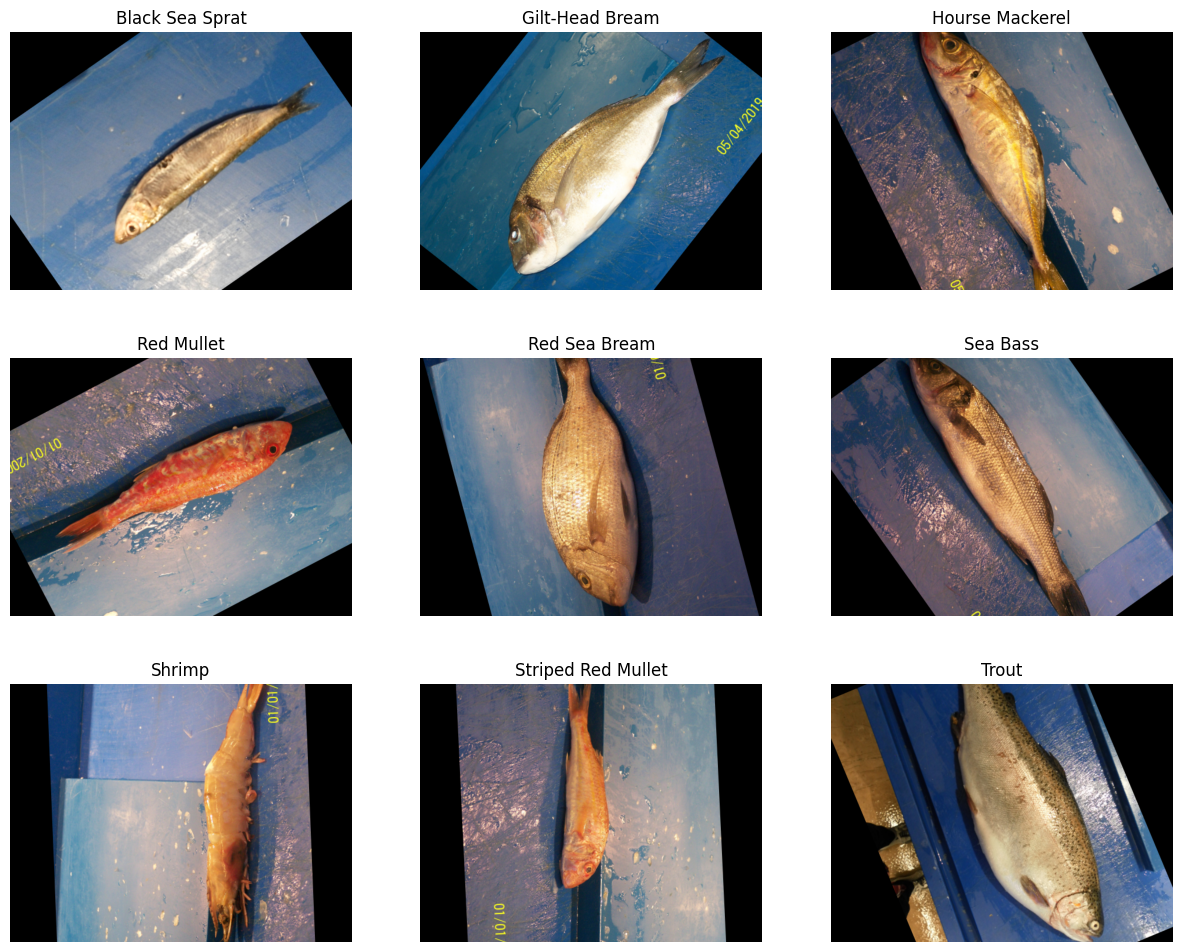

In [10]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [11]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [12]:
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


In [13]:
'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")

In [15]:
'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
#Using Keras Image Data Generator to preprocess our images with the model we wish to use
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [17]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [18]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

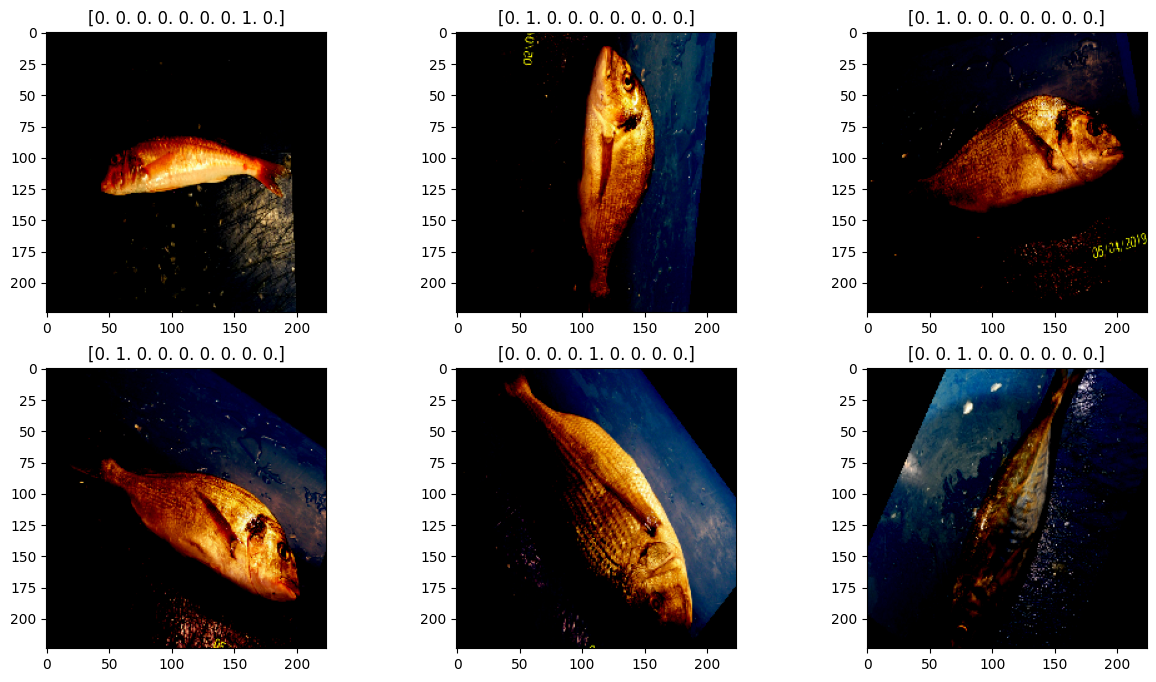

In [19]:
#Plotting images after pre-processing

fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

In [20]:
#Importing our pretrained model : MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
#Creating our model inputs
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [22]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00250
Test Accuracy: 99.94%


In [23]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 [==============================] - 35s 603ms/step


In [24]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [25]:
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

,path,label,pred
0,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Striped Red Mullet,Striped Red Mullet
1,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Gilt-Head Bream,Gilt-Head Bream
2,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Black Sea Sprat,Black Sea Sprat
3,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Red Sea Bream,Red Sea Bream
4,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Trout,Trout
5,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Trout,Trout
6,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Sea Bass,Sea Bass
7,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Trout,Trout
8,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Red Mullet,Red Mullet
9,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Red Sea Bream,Red Sea Bream


In [26]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]

,path,label,pred
1380,//content/drive/MyDrive/Kaggle/Fish_Dataset/Fi...,Sea Bass,Red Sea Bream
